In [ ]:
# -----------------------------
# 1️⃣ Install Kaggle API
# -----------------------------
# !pip install kaggle

# -----------------------------
# 2️⃣ Upload kaggle.json token
# -----------------------------
from google.colab import files
uploaded = files.upload()  # Upload the kaggle.json file here

# -----------------------------
# 3️⃣ Configure Kaggle API
# -----------------------------
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# -----------------------------
# 4️⃣ Download Kaggle dataset
# -----------------------------
dataset_path = 'vikashrajluhaniwal/fashion-images'  # Correct dataset path
!kaggle datasets download -d {dataset_path} -q

# -----------------------------
# 5️⃣ Extract the ZIP file
# -----------------------------
import zipfile

# Get the downloaded file name automatically
zip_files = [f for f in os.listdir() if f.endswith('.zip')]
if len(zip_files) == 0:
    raise FileNotFoundError("No ZIP file found in Colab environment!")

zip_path = zip_files[0]  # first ZIP file
extract_path = '/content/dataset'  # folder to extract

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted to:", extract_path)


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/vikashrajluhaniwal/fashion-images
License(s): CC0-1.0
✅ Dataset extracted to: /content/dataset


In [ ]:
import os

dataset_path = '/content/dataset'

file_count = 0
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        print(os.path.join(root, file))
        file_count += 1

print("Total files found:", file_count)



/content/dataset/data/fashion.csv
/content/dataset/data/Apparel/Boys/Images/images_with_product_ids/24909.jpg
/content/dataset/data/Apparel/Boys/Images/images_with_product_ids/43581.jpg
/content/dataset/data/Apparel/Boys/Images/images_with_product_ids/54959.jpg
/content/dataset/data/Apparel/Boys/Images/images_with_product_ids/40934.jpg
/content/dataset/data/Apparel/Boys/Images/images_with_product_ids/4730.jpg
/content/dataset/data/Apparel/Boys/Images/images_with_product_ids/38952.jpg
/content/dataset/data/Apparel/Boys/Images/images_with_product_ids/37221.jpg
/content/dataset/data/Apparel/Boys/Images/images_with_product_ids/33142.jpg
/content/dataset/data/Apparel/Boys/Images/images_with_product_ids/22637.jpg
/content/dataset/data/Apparel/Boys/Images/images_with_product_ids/41982.jpg
/content/dataset/data/Apparel/Boys/Images/images_with_product_ids/43698.jpg
/content/dataset/data/Apparel/Boys/Images/images_with_product_ids/22628.jpg
/content/dataset/data/Apparel/Boys/Images/images_with_p

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model


In [ ]:
# Load CSV
csv_path = '/content/dataset/data/fashion.csv'
dataset_root = '/content/dataset/data'

df = pd.read_csv(csv_path)

# Function to find image path
def find_image_path(product_id):
    for root, dirs, files in os.walk(dataset_root):
        filename = f"{product_id}.jpg"
        if filename in files:
            return os.path.join(root, filename)
    return None

# Use the correct column name from CSV
df['image_path'] = df['ProductId'].apply(find_image_path)

# Drop rows with missing images
df = df.dropna(subset=['image_path'])

print("Total valid images:", len(df))
df.head()



Total valid images: 2906


,ProductId,Gender,Category,SubCategory,ProductType,Colour,Usage,ProductTitle,Image,ImageURL,image_path
0,42419,Girls,Apparel,Topwear,Tops,White,Casual,Gini and Jony Girls Knit White Top,42419.jpg,http://assets.myntassets.com/v1/images/style/p...,/content/dataset/data/Apparel/Girls/Images/ima...
1,34009,Girls,Apparel,Topwear,Tops,Black,Casual,Gini and Jony Girls Black Top,34009.jpg,http://assets.myntassets.com/v1/images/style/p...,/content/dataset/data/Apparel/Girls/Images/ima...
2,40143,Girls,Apparel,Topwear,Tops,Blue,Casual,Gini and Jony Girls Pretty Blossom Blue Top,40143.jpg,http://assets.myntassets.com/v1/images/style/p...,/content/dataset/data/Apparel/Girls/Images/ima...
3,23623,Girls,Apparel,Topwear,Tops,Pink,Casual,Doodle Kids Girls Pink I love Shopping Top,23623.jpg,http://assets.myntassets.com/v1/images/style/p...,/content/dataset/data/Apparel/Girls/Images/ima...
4,47154,Girls,Apparel,Bottomwear,Capris,Black,Casual,Gini and Jony Girls Black Capris,47154.jpg,http://assets.myntassets.com/v1/images/style/p...,/content/dataset/data/Apparel/Girls/Images/ima...


In [ ]:
# Load ResNet50 without top layer, include global average pooling
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
print("ResNet50 loaded for feature extraction")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
ResNet50 loaded for feature extraction


In [ ]:
def get_embedding(img_path, model=base_model, target_size=(224,224)):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    embedding = model.predict(x, verbose=0)
    return embedding.flatten()


In [ ]:
embeddings = []
for img_path in tqdm(df['image_path'].values):
    emb = get_embedding(img_path)
    embeddings.append(emb)

embeddings = np.array(embeddings)
print("Embeddings shape:", embeddings.shape)


100%|██████████| 2906/2906 [19:59<00:00,  2.42it/s]

Embeddings shape: (2906, 2048)


In [ ]:
def recommend_similar(uploaded_img_path, embeddings, df, top_k=5):
    # Get embedding of uploaded image
    query_emb = get_embedding(uploaded_img_path)

    # Compute cosine similarity
    sims = cosine_similarity([query_emb], embeddings)[0]

    # Get top_k indices
    top_indices = sims.argsort()[-top_k:][::-1]

    # Return corresponding image paths and similarity scores
    # Use the correct CSV column names
    results = df.iloc[top_indices][['image_path', 'Category']].copy()
    results['similarity'] = sims[top_indices]
    return results



In [ ]:
from google.colab import files

uploaded = files.upload()
uploaded_file = list(uploaded.keys())[0]
print("Uploaded image:", uploaded_file)

# Get recommendations
recommendations = recommend_similar(uploaded_file, embeddings, df, top_k=5)
print(recommendations)


Saving jeans.avif to jeans.avif
Uploaded image: jeans.avif
                                             image_path Category  similarity
653   /content/dataset/data/Apparel/Boys/Images/imag...  Apparel    0.894827
642   /content/dataset/data/Apparel/Boys/Images/imag...  Apparel    0.894827
835   /content/dataset/data/Apparel/Boys/Images/imag...  Apparel    0.894827
1270  /content/dataset/data/Apparel/Boys/Images/imag...  Apparel    0.891115
1142  /content/dataset/data/Apparel/Boys/Images/imag...  Apparel    0.891115


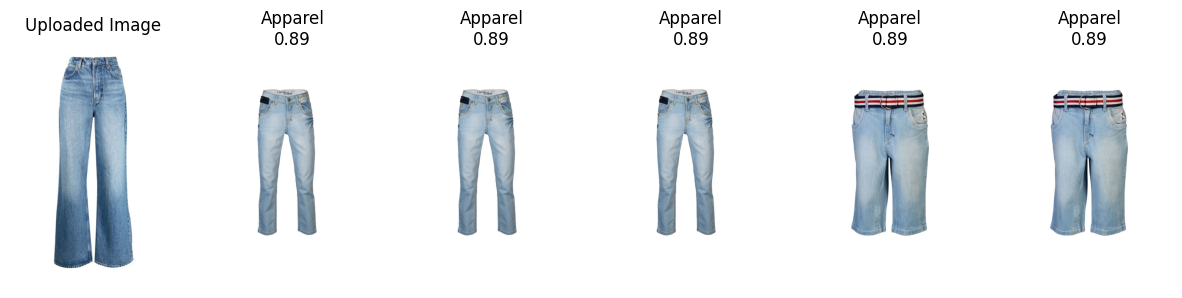

In [ ]:
plt.figure(figsize=(15,5))

# Display uploaded image
plt.subplot(1,6,1)
img = cv2.imread(uploaded_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title("Uploaded Image")
plt.axis('off')

# Display recommended images
for i, row in enumerate(recommendations.itertuples(), start=2):
    plt.subplot(1,6,i)
    rec_img = cv2.imread(row.image_path)
    rec_img = cv2.cvtColor(rec_img, cv2.COLOR_BGR2RGB)
    plt.imshow(rec_img)
    plt.title(f"{row.Category}\n{row.similarity:.2f}")  # <-- Use 'Category' with uppercase
    plt.axis('off')

plt.show()



In [ ]:
import pickle

# Save embeddings, image paths, and categories
data_to_save = {
    'embeddings': embeddings,
    'image_paths': df['image_path'].values,
    'categories': df['Category'].values
}

with open('fashion_embeddings.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

print("Embeddings and metadata saved successfully!")


Embeddings and metadata saved successfully!


In [ ]:
# =============================
# STEP 1: Load CSV
# =============================
import pandas as pd
from sentence_transformers import SentenceTransformer

df = pd.read_csv("fashion.csv")   # use your csv name

# Combine useful text fields into one
df["text"] = df[["ProductTitle", "Category", "SubCategory", "Colour", "Usage"]].fillna("").agg(" ".join, axis=1)

# =============================
# STEP 2: Generate Text Embeddings
# =============================
text_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
text_embeddings = text_model.encode(df["text"].tolist(), show_progress_bar=True)

# =============================
# STEP 3: Save Text Embeddings
# =============================
import pickle

with open("fashion_embeddings_text.pkl", "wb") as f:
    pickle.dump({
        "text_embeddings": text_embeddings,
        "texts": df["text"].tolist(),
        "image_paths": df["Image"].tolist(),        # from CSV
        "categories": df["Category"].tolist(),      # from CSV
        "titles": df["ProductTitle"].tolist()       # keep product titles for display
    }, f)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/91 [00:00<?, ?it/s]